In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, auc, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from data_repository import DataRepository

# Chuẩn bị dữ liệu

In [2]:
data_repo = DataRepository("../.env")
#Unclean data
X_Train, y_train, X_validation, y_validation, X_test, y_test = data_repo.load_current_data(clean_data=False)

In [3]:
print(f"Train dataset: X: {X_Train.shape}, y: {y_train.shape}")
print(f"Validation dataset: X: {X_validation.shape}, y: {y_validation.shape}")
print(f"Test dataset X: {X_test.shape}, y{y_test.shape}")

Train dataset: X: (8400, 9000), y: (8400,)
Validation dataset: X: (1800, 9000), y: (1800,)
Test dataset X: (1800, 9000), y(1800,)


__Label encoder__

In [5]:
# Chuyển đổi danh sách labels thành mã số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)
y_test = label_encoder.transform(y_test)

In [6]:
print(list(label_encoder.classes_))
print(label_encoder.transform(list(label_encoder.classes_)))

['error', 'normal', 'overcurrent', 'overheating', 'zero']
[0 1 2 3 4]


In [7]:
def evaluate_and_print_results(y_pred, y_pred_proba, y_test, label_encoder: LabelEncoder):
    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    #conf_matrix to return
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Tính toán F1-Score
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    #Precision and recall
    precision = precision_score(y_test, y_pred, average='weighted')  
    recall = recall_score(y_test, y_pred, average='weighted')
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    auc_values = []
    for i in range(n_classes):
        # Create binary labels for each class
        y_test_class = np.where(y_test == i, 1, 0)
        auc = roc_auc_score(y_test_class, y_pred_proba[:, i])
        auc_values.append(auc)
    # Tính trung bình AUC (macro-average)
    macro_avg_auc = np.mean(auc_values)  # Avoid division by zero if auc_values is empty
    #Revert transform
    y_test = label_encoder.inverse_transform(y_test)
    y_pred = label_encoder.inverse_transform(y_pred)
    # Print results
    print(classification_report(y_test, y_pred))
    print()
    print("Custom reports")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score (Macro): {f1_macro}")
    print(f"Macro-average AUC (SVM): {macro_avg_auc}")
    return conf_matrix

def plot_auc_curve(y_pred_proba, y_test, label_encoder: LabelEncoder, model_name):
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        class_name = label_encoder.inverse_transform([i])[0]
        y_test_class = np.where(y_test == i, 1, 0)
        fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_conf_matrix(conf_matrix, model_name):
    # Define the class labels
    class_labels = ['error', 'normal', 'overcurrent', 'overheating', 'zero']
    # Create a mappable object for the confusion matrix.
    mappable = plt.imshow(conf_matrix, cmap='Blues')
    # Plot the colorbar
    plt.colorbar(mappable)
    # Add labels to the plot using the class labels.
    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    # Add text to the confusion matrix.
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center')
    # Set plot title and labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# SVM

## Xây dựng mô hình

In [8]:
from sklearn.svm import SVC
svm_model_current = SVC(kernel='rbf', random_state=42, probability=True)
svm_model_current.fit(X_Train, y_train)

SVC(probability=True, random_state=42)

## Đánh giá mô hình

In [9]:
svm_y_pred = svm_model_current.predict(X_validation)
svm_y_pred_proba = svm_model_current.predict_proba(X_validation)
svm_model_name = "SVM (RMS current)"

              precision    recall  f1-score   support

       error       0.96      0.71      0.81       366
      normal       0.95      0.93      0.94       356
 overcurrent       0.98      1.00      0.99       371
 overheating       0.84      0.91      0.88       349
        zero       0.85      1.00      0.92       358

    accuracy                           0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800


Custom reports
Precision: 0.9148716253026469
Recall: 0.9094444444444445
Accuracy: 0.9094444444444445
F1-Score (Macro): 0.9065723243012414
Macro-average AUC (SVM): 0.9946165571119995


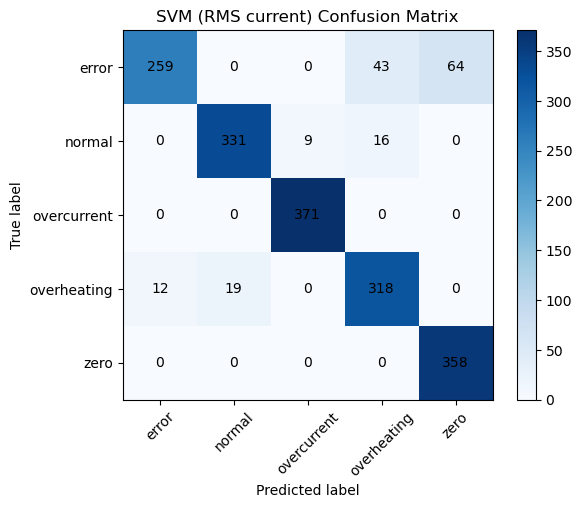

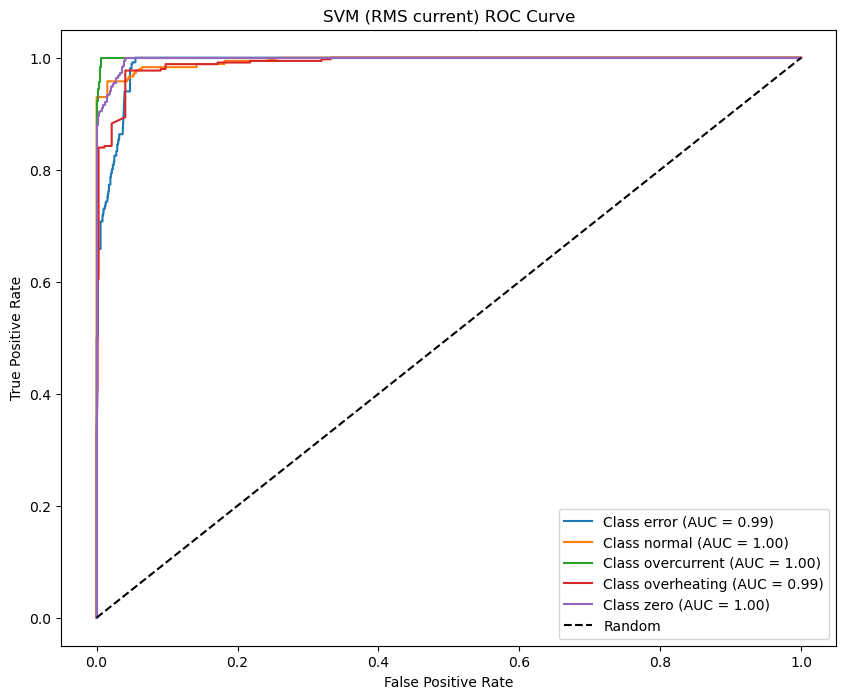

In [10]:
svm_conf_matrix = evaluate_and_print_results(y_pred=svm_y_pred, y_pred_proba=svm_y_pred_proba, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=svm_conf_matrix, model_name=svm_model_name)
plot_auc_curve(y_pred_proba=svm_y_pred_proba, y_test=y_validation, label_encoder=label_encoder, model_name=svm_model_name)

In [11]:
svm_y_pred = svm_model_current.predict(X_test)
svm_y_pred_proba = svm_model_current.predict_proba(X_test)

              precision    recall  f1-score   support

       error       0.96      0.76      0.85       360
      normal       0.91      0.92      0.91       351
 overcurrent       0.98      1.00      0.99       364
 overheating       0.83      0.89      0.86       360
        zero       0.90      1.00      0.95       365

    accuracy                           0.91      1800
   macro avg       0.92      0.91      0.91      1800
weighted avg       0.92      0.91      0.91      1800


Custom reports
Precision: 0.916825002213324
Recall: 0.9133333333333333
Accuracy: 0.9133333333333333
F1-Score (Macro): 0.9116461570990195
Macro-average AUC (SVM): 0.9938387748455906


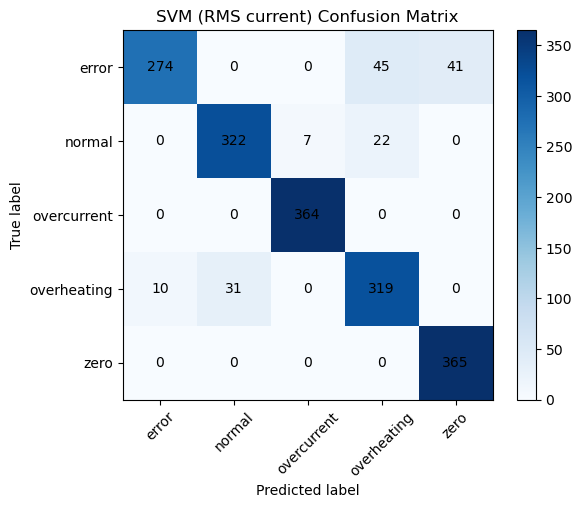

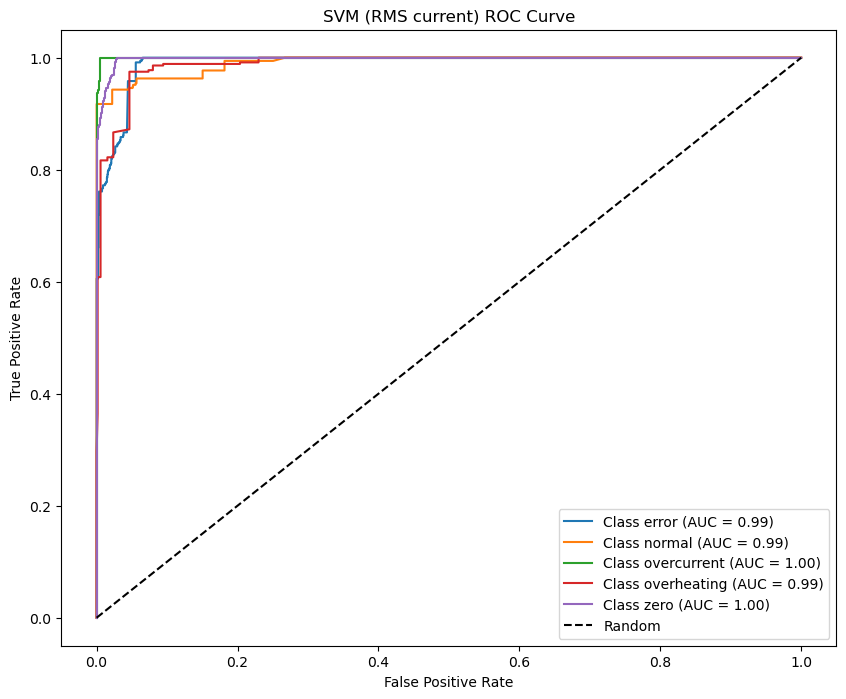

In [12]:
svm_conf_matrix = evaluate_and_print_results(y_pred=svm_y_pred, y_pred_proba=svm_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=svm_conf_matrix, model_name=svm_model_name)
plot_auc_curve(y_pred_proba=svm_y_pred_proba, y_test=y_test, label_encoder=label_encoder, model_name=svm_model_name)

# Random Forest

## Xây dựng mô hình

In [13]:
# Tạo mô hình SVM
from sklearn.ensemble import RandomForestClassifier
rf_current = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_current.fit(X_Train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

## Đánh giá mô hình

In [14]:
y_pred = rf_current.predict(X_validation)
y_pred_proba = rf_current.predict_proba(X_validation)
rf_model_name = "Random Forest (RMS current)"

              precision    recall  f1-score   support

       error       0.93      0.91      0.92       366
      normal       1.00      0.93      0.97       356
 overcurrent       0.98      1.00      0.99       371
 overheating       0.96      0.98      0.97       349
        zero       0.91      0.95      0.93       358

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800


Custom reports
Precision: 0.9562899340890391
Recall: 0.9555555555555556
Accuracy: 0.9555555555555556
F1-Score (Macro): 0.9555530789976763
Macro-average AUC (SVM): 0.9977415102472367


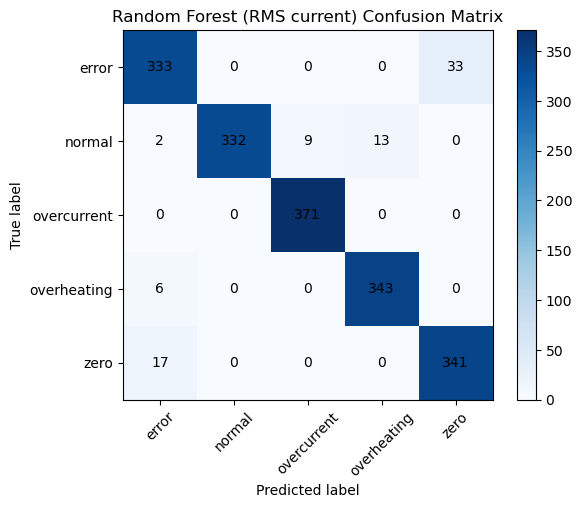

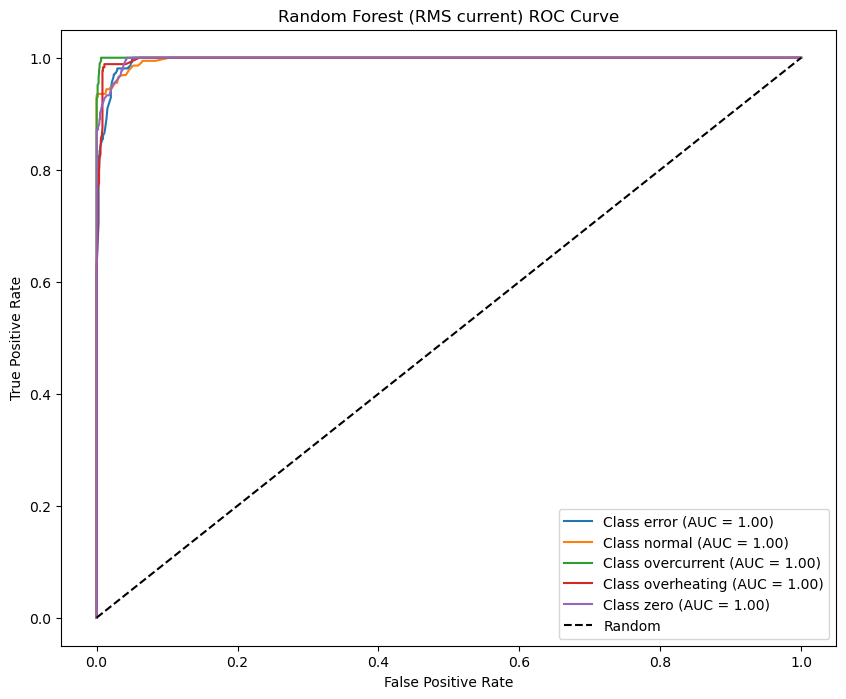

In [15]:
rf_val_cm = evaluate_and_print_results(y_pred=y_pred, y_pred_proba=y_pred_proba, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=rf_val_cm, model_name=rf_model_name)
plot_auc_curve(y_pred_proba=y_pred_proba, y_test=y_validation, label_encoder=label_encoder, model_name=rf_model_name)

In [16]:
rf_y_pred = rf_current.predict(X_test)
rf_y_pred_proba = rf_current.predict_proba(X_test)

              precision    recall  f1-score   support

       error       0.90      0.94      0.92       360
      normal       1.00      0.92      0.96       351
 overcurrent       0.98      1.00      0.99       364
 overheating       0.96      0.99      0.98       360
        zero       0.94      0.92      0.93       365

    accuracy                           0.95      1800
   macro avg       0.96      0.95      0.95      1800
weighted avg       0.96      0.95      0.95      1800


Custom reports
Precision: 0.9553655138861801
Recall: 0.9544444444444444
Accuracy: 0.9544444444444444
F1-Score (Macro): 0.9544378823784445
Macro-average AUC (SVM): 0.9979909095374875


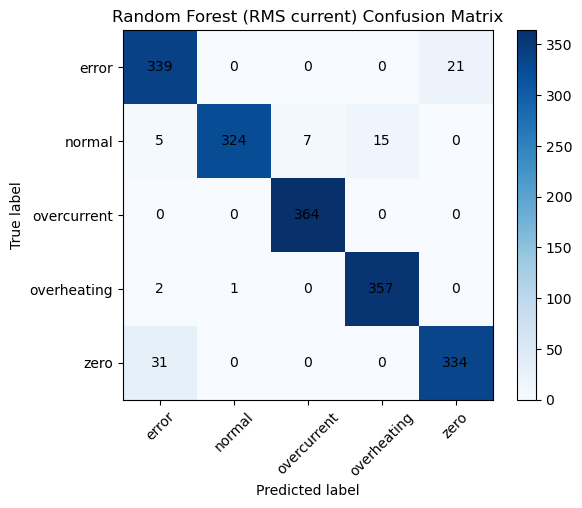

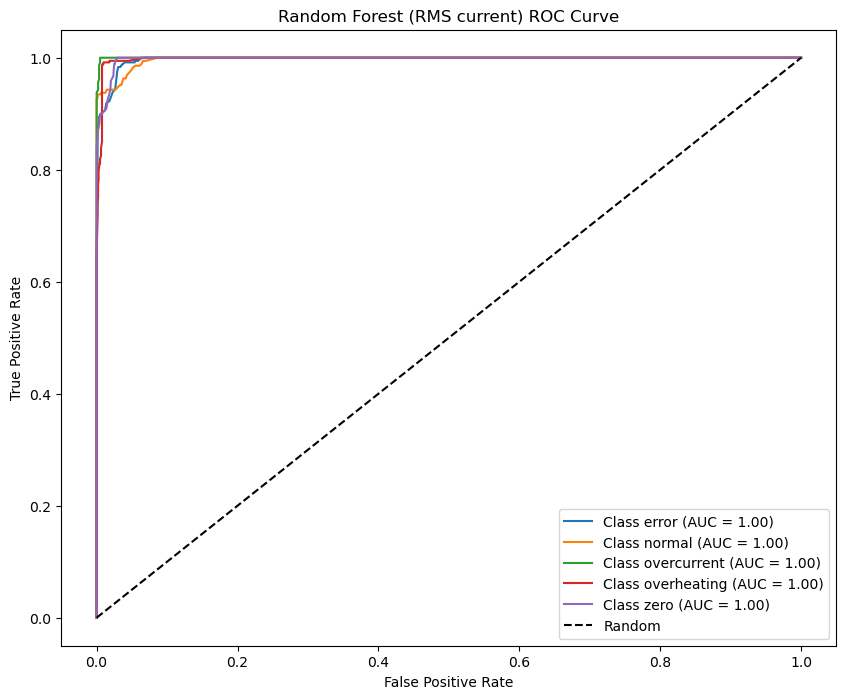

In [17]:
rf_cm = evaluate_and_print_results(y_pred=rf_y_pred, y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=rf_cm, model_name=rf_model_name)
plot_auc_curve(y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder, model_name=rf_model_name)

# XgBoost

## Xây dựng mô hình

In [18]:
from xgboost import XGBClassifier
xgboost_current = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_current.fit(X_Train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Đánh giá mô hình

In [19]:
xgb_y_pred = xgboost_current.predict(X_validation)
xgb_y_pred_proba = xgboost_current.predict_proba(X_validation)
xgb_model_name = "XgBoost (RMS Current)"

              precision    recall  f1-score   support

       error       0.93      0.92      0.92       366
      normal       0.96      0.93      0.95       356
 overcurrent       0.98      1.00      0.99       371
 overheating       0.95      0.94      0.94       349
        zero       0.93      0.95      0.94       358

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800


Custom reports
Precision: 0.9483631376875744
Recall: 0.9483333333333334
Accuracy: 0.9483333333333334
F1-Score (Macro): 0.9480328320212885
Macro-average AUC (SVM): 0.9969595918057941


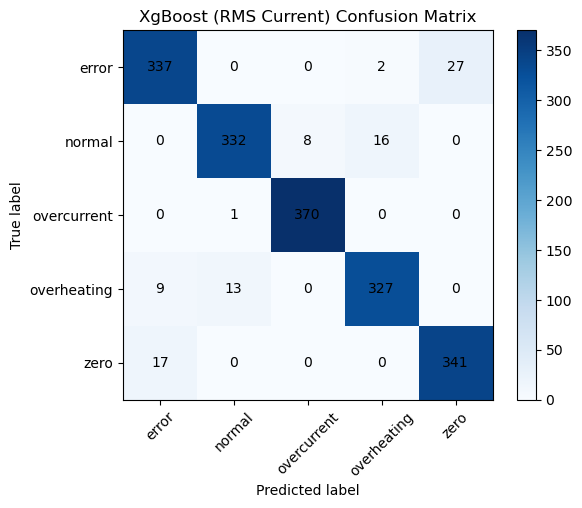

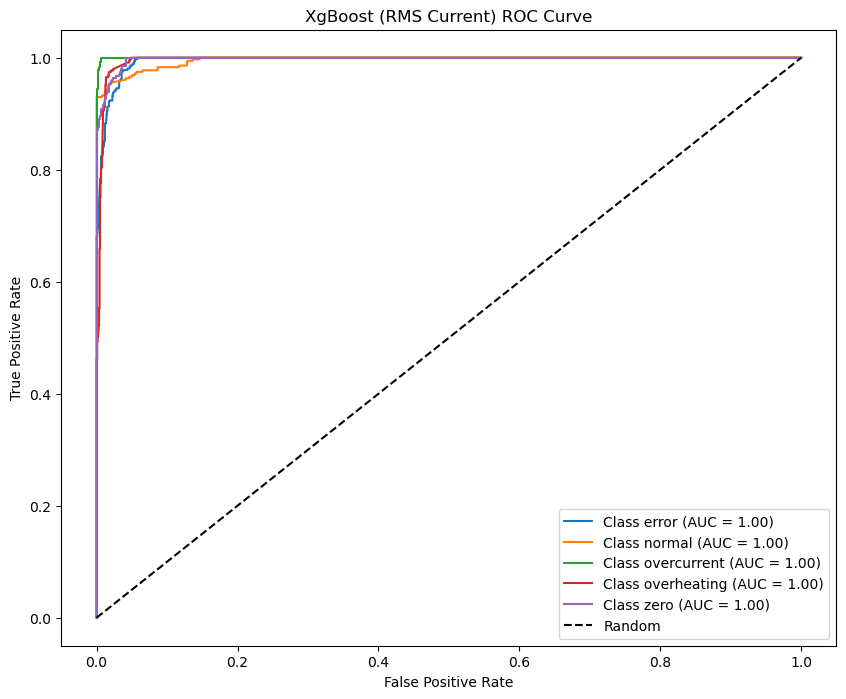

In [20]:
xgb_val_cm = evaluate_and_print_results(y_pred=xgb_y_pred, y_pred_proba=xgb_y_pred_proba, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=xgb_val_cm, model_name=xgb_model_name)
plot_auc_curve(y_pred_proba=xgb_y_pred_proba, y_test=y_validation, label_encoder=label_encoder, model_name=xgb_model_name)

In [21]:
xgb_y_pred = xgboost_current.predict(X_test)
xgb_y_pred_proba = xgboost_current.predict_proba(X_test)

              precision    recall  f1-score   support

       error       0.90      0.93      0.92       360
      normal       0.98      0.93      0.95       351
 overcurrent       0.98      1.00      0.99       364
 overheating       0.93      0.95      0.94       360
        zero       0.95      0.93      0.94       365

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800


Custom reports
Precision: 0.948426892251078
Recall: 0.9477777777777778
Accuracy: 0.9477777777777778
F1-Score (Macro): 0.9477604660952691
Macro-average AUC (SVM): 0.9970920130173987


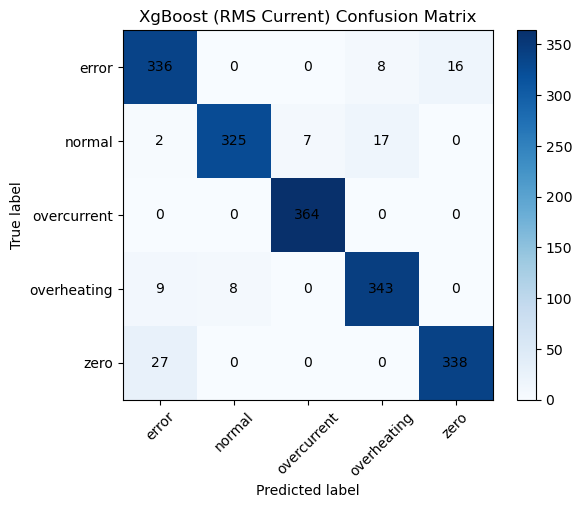

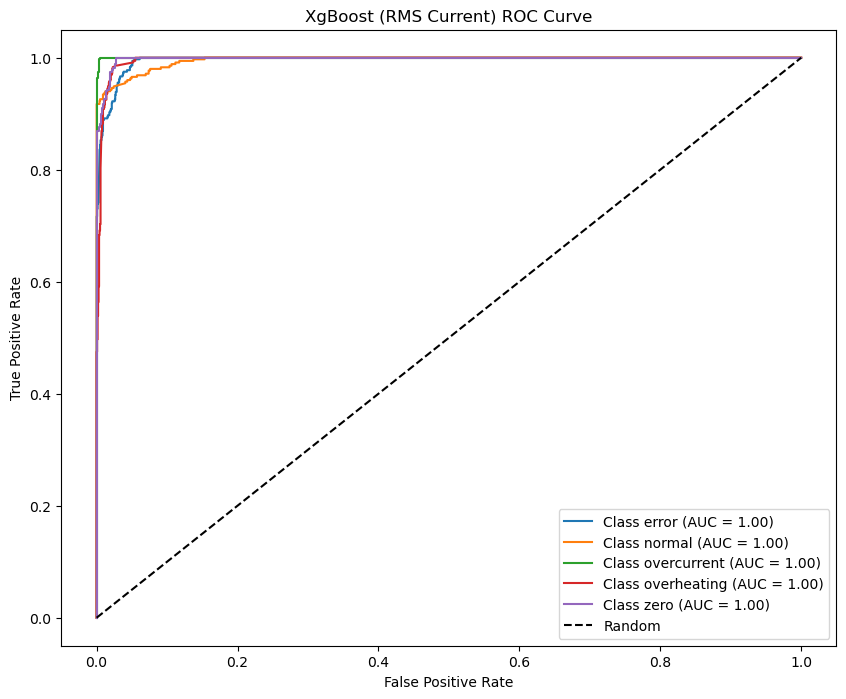

In [22]:
xgb_val_cm = evaluate_and_print_results(y_pred=xgb_y_pred, y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=xgb_val_cm, model_name=xgb_model_name)
plot_auc_curve(y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder, model_name=xgb_model_name)